In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_1minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*60:, -1])
n_p = n_p + 365*24*3*60

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 60 + 1 : , :]
values = np.concatenate((a, b), axis=0)

# result variable
result = np.zeros((5, 24))

Train on 65700 samples, validate on 16393 samples
Epoch 1/100
 - 27s - loss: 0.0218 - val_loss: 0.0158
Epoch 2/100
 - 27s - loss: 0.0157 - val_loss: 0.0161
Epoch 3/100
 - 26s - loss: 0.0154 - val_loss: 0.0155
Epoch 4/100
 - 26s - loss: 0.0152 - val_loss: 0.0151
Epoch 5/100
 - 26s - loss: 0.0151 - val_loss: 0.0153
Epoch 6/100
 - 27s - loss: 0.0151 - val_loss: 0.0149
Epoch 7/100
 - 27s - loss: 0.0150 - val_loss: 0.0149
Epoch 8/100
 - 26s - loss: 0.0150 - val_loss: 0.0128
Epoch 9/100
 - 27s - loss: 0.0150 - val_loss: 0.0141
Epoch 10/100
 - 26s - loss: 0.0149 - val_loss: 0.0123
Epoch 11/100
 - 26s - loss: 0.0149 - val_loss: 0.0128
Epoch 12/100
 - 27s - loss: 0.0149 - val_loss: 0.0124
Epoch 13/100
 - 27s - loss: 0.0149 - val_loss: 0.0124
Epoch 14/100
 - 26s - loss: 0.0149 - val_loss: 0.0122
Epoch 15/100
 - 26s - loss: 0.0148 - val_loss: 0.0122
Epoch 16/100
 - 27s - loss: 0.0148 - val_loss: 0.0128
Epoch 17/100
 - 26s - loss: 0.0148 - val_loss: 0.0122
Epoch 18/100
 - 26s - loss: 0.0148 - val_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


Train on 65700 samples, validate on 16393 samples
Epoch 1/100
 - 25s - loss: 0.0335 - val_loss: 0.0159
Epoch 2/100
 - 24s - loss: 0.0159 - val_loss: 0.0127
Epoch 3/100
 - 24s - loss: 0.0155 - val_loss: 0.0137
Epoch 4/100
 - 24s - loss: 0.0154 - val_loss: 0.0126
Epoch 5/100
 - 24s - loss: 0.0152 - val_loss: 0.0125
Epoch 6/100
 - 24s - loss: 0.0152 - val_loss: 0.0124
Epoch 7/100
 - 24s - loss: 0.0152 - val_loss: 0.0124
Epoch 8/100
 - 24s - loss: 0.0150 - val_loss: 0.0134
Epoch 9/100
 - 24s - loss: 0.0151 - val_loss: 0.0126
Epoch 10/100
 - 25s - loss: 0.0150 - val_loss: 0.0126
Epoch 11/100
 - 25s - loss: 0.0150 - val_loss: 0.0125
Epoch 12/100
 - 26s - loss: 0.0149 - val_loss: 0.0133
Epoch 13/100
 - 25s - loss: 0.0149 - val_loss: 0.0141
Epoch 14/100
 - 25s - loss: 0.0149 - val_loss: 0.0122
Epoch 15/100
 - 25s - loss: 0.0149 - val_loss: 0.0135
Epoch 16/100
 - 25s - loss: 0.0149 - val_loss: 0.0140
Epoch 17/100
 - 24s - loss: 0.0148 - val_loss: 0.0130
Epoch 18/100
 - 25s - loss: 0.0148 - val_

 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 52/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 53/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 54/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 55/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 58/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 65/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 67/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 26s - loss: 0.0146 - val_

Epoch 2/100
 - 27s - loss: 0.0157 - val_loss: 0.0131
Epoch 3/100
 - 27s - loss: 0.0155 - val_loss: 0.0135
Epoch 4/100
 - 27s - loss: 0.0153 - val_loss: 0.0124
Epoch 5/100
 - 27s - loss: 0.0152 - val_loss: 0.0123
Epoch 6/100
 - 26s - loss: 0.0152 - val_loss: 0.0139
Epoch 7/100
 - 26s - loss: 0.0151 - val_loss: 0.0157
Epoch 8/100
 - 27s - loss: 0.0151 - val_loss: 0.0151
Epoch 9/100
 - 26s - loss: 0.0151 - val_loss: 0.0134
Epoch 10/100
 - 27s - loss: 0.0150 - val_loss: 0.0143
Epoch 11/100
 - 27s - loss: 0.0150 - val_loss: 0.0142
Epoch 12/100
 - 26s - loss: 0.0150 - val_loss: 0.0140
Epoch 13/100
 - 27s - loss: 0.0149 - val_loss: 0.0134
Epoch 14/100
 - 27s - loss: 0.0149 - val_loss: 0.0143
Epoch 15/100
 - 27s - loss: 0.0149 - val_loss: 0.0146
Epoch 16/100
 - 27s - loss: 0.0149 - val_loss: 0.0146
Epoch 17/100
 - 27s - loss: 0.0149 - val_loss: 0.0124
Epoch 18/100
 - 27s - loss: 0.0148 - val_loss: 0.0135
Epoch 19/100
 - 27s - loss: 0.0148 - val_loss: 0.0132
Epoch 20/100
 - 27s - loss: 0.0148 -

 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 54/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 55/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 58/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 26s - loss: 0.0146 - val_loss: 0.0123
Epoch 60/100
 - 26s - loss: 0.0146 - val_loss: 0.0122
Epoch 61/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 28s - loss: 0.0146 - val_loss: 0.0122
Epoch 65/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 27s - loss: 0.0145 - val_loss: 0.0121
Epoch 67/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 69/100
 - 26s - loss: 0.0145 - val_loss: 0.0121
Epoch 70/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 71/100
 - 27s - loss: 0.0146 - val_

Epoch 4/100
 - 26s - loss: 0.0153 - val_loss: 0.0123
Epoch 5/100
 - 27s - loss: 0.0151 - val_loss: 0.0122
Epoch 6/100
 - 27s - loss: 0.0151 - val_loss: 0.0125
Epoch 7/100
 - 27s - loss: 0.0150 - val_loss: 0.0123
Epoch 8/100
 - 26s - loss: 0.0150 - val_loss: 0.0124
Epoch 9/100
 - 27s - loss: 0.0150 - val_loss: 0.0125
Epoch 10/100
 - 26s - loss: 0.0150 - val_loss: 0.0123
Epoch 11/100
 - 27s - loss: 0.0149 - val_loss: 0.0123
Epoch 12/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 13/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 14/100
 - 27s - loss: 0.0149 - val_loss: 0.0122
Epoch 15/100
 - 27s - loss: 0.0149 - val_loss: 0.0122
Epoch 16/100
 - 26s - loss: 0.0148 - val_loss: 0.0122
Epoch 17/100
 - 27s - loss: 0.0148 - val_loss: 0.0124
Epoch 18/100
 - 27s - loss: 0.0149 - val_loss: 0.0122
Epoch 19/100
 - 27s - loss: 0.0148 - val_loss: 0.0122
Epoch 20/100
 - 26s - loss: 0.0148 - val_loss: 0.0122
Epoch 21/100
 - 26s - loss: 0.0148 - val_loss: 0.0122
Epoch 22/100
 - 26s - loss: 0.0148

 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 58/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 65/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 67/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 25s - loss: 0.0146 - val_loss: 0.0121
Epoch 70/100
 - 24s - loss: 0.0146 - val_loss: 0.0122
Epoch 71/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 72/100
 - 24s - loss: 0.0146 - val_loss: 0.0121
Epoch 73/100
 - 24s - loss: 0.0146 - val_

Epoch 6/100
 - 27s - loss: 0.0152 - val_loss: 0.0124
Epoch 7/100
 - 27s - loss: 0.0152 - val_loss: 0.0129
Epoch 8/100
 - 27s - loss: 0.0152 - val_loss: 0.0141
Epoch 9/100
 - 27s - loss: 0.0151 - val_loss: 0.0131
Epoch 10/100
 - 27s - loss: 0.0150 - val_loss: 0.0125
Epoch 11/100
 - 27s - loss: 0.0150 - val_loss: 0.0126
Epoch 12/100
 - 27s - loss: 0.0150 - val_loss: 0.0128
Epoch 13/100
 - 27s - loss: 0.0149 - val_loss: 0.0128
Epoch 14/100
 - 27s - loss: 0.0149 - val_loss: 0.0128
Epoch 15/100
 - 27s - loss: 0.0149 - val_loss: 0.0124
Epoch 16/100
 - 27s - loss: 0.0149 - val_loss: 0.0128
Epoch 17/100
 - 27s - loss: 0.0149 - val_loss: 0.0128
Epoch 18/100
 - 29s - loss: 0.0148 - val_loss: 0.0126
Epoch 19/100
 - 27s - loss: 0.0148 - val_loss: 0.0122
Epoch 20/100
 - 28s - loss: 0.0149 - val_loss: 0.0122
Epoch 21/100
 - 28s - loss: 0.0148 - val_loss: 0.0121
Epoch 22/100
 - 27s - loss: 0.0148 - val_loss: 0.0123
Epoch 23/100
 - 27s - loss: 0.0148 - val_loss: 0.0121
Epoch 24/100
 - 27s - loss: 0.01

 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 58/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 31s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 65/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 67/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 70/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 71/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 72/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 73/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 74/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 75/100
 - 26s - loss: 0.0146 - val_

Epoch 8/100
 - 27s - loss: 0.0149 - val_loss: 0.0138
Epoch 9/100
 - 27s - loss: 0.0149 - val_loss: 0.0143
Epoch 10/100
 - 27s - loss: 0.0149 - val_loss: 0.0137
Epoch 11/100
 - 26s - loss: 0.0149 - val_loss: 0.0133
Epoch 12/100
 - 27s - loss: 0.0148 - val_loss: 0.0134
Epoch 13/100
 - 27s - loss: 0.0148 - val_loss: 0.0137
Epoch 14/100
 - 27s - loss: 0.0148 - val_loss: 0.0124
Epoch 15/100
 - 27s - loss: 0.0148 - val_loss: 0.0125
Epoch 16/100
 - 27s - loss: 0.0148 - val_loss: 0.0123
Epoch 17/100
 - 26s - loss: 0.0147 - val_loss: 0.0122
Epoch 18/100
 - 27s - loss: 0.0147 - val_loss: 0.0126
Epoch 19/100
 - 27s - loss: 0.0147 - val_loss: 0.0122
Epoch 20/100
 - 27s - loss: 0.0147 - val_loss: 0.0122
Epoch 21/100
 - 27s - loss: 0.0147 - val_loss: 0.0122
Epoch 22/100
 - 27s - loss: 0.0147 - val_loss: 0.0122
Epoch 23/100
 - 26s - loss: 0.0147 - val_loss: 0.0123
Epoch 24/100
 - 26s - loss: 0.0147 - val_loss: 0.0121
Epoch 25/100
 - 27s - loss: 0.0147 - val_loss: 0.0122
Epoch 26/100
 - 27s - loss: 0.

KeyboardInterrupt: 

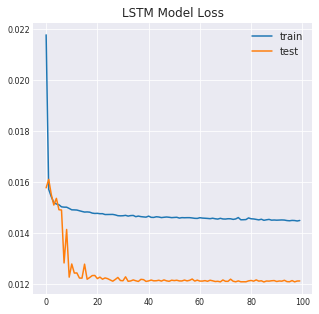

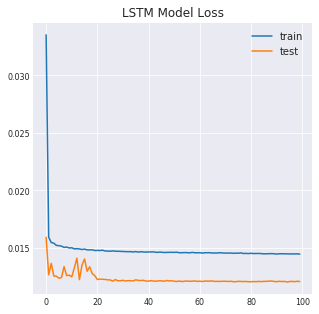

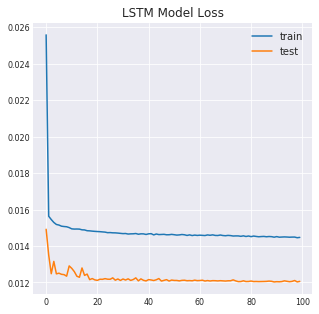

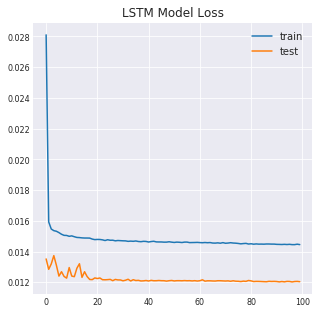

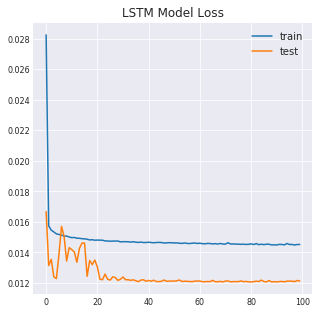

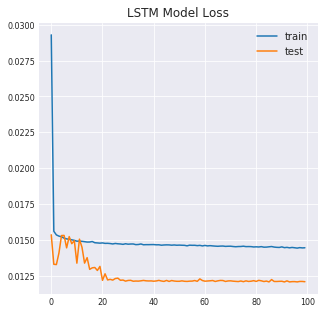

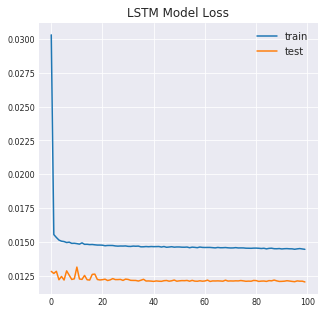

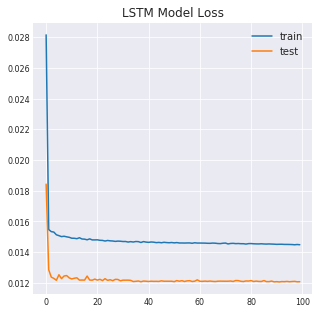

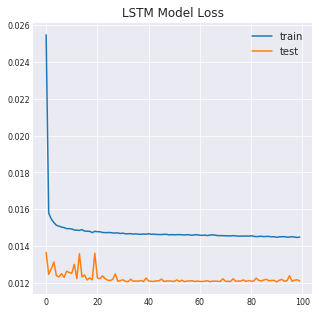

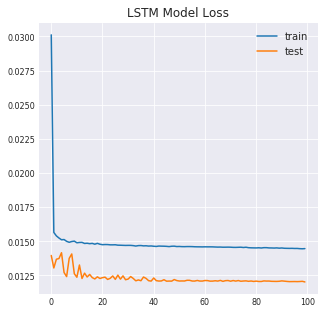

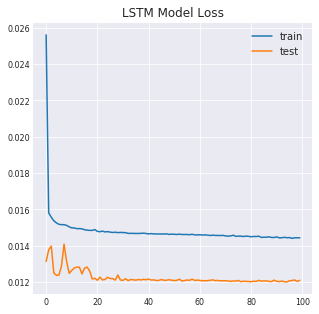

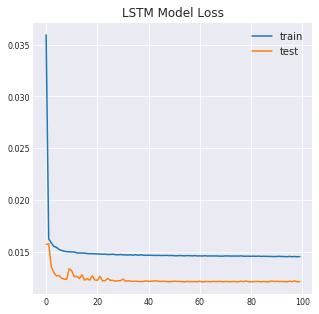

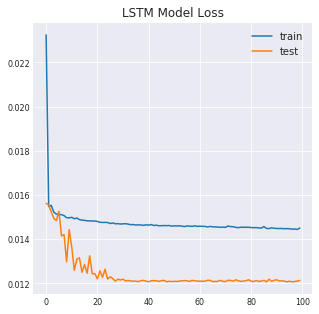

In [7]:
for i in range (24):
    values = total_values[total_values[:, -4] == total_values[i, 1]]
    n_train_hours = 365*3*60
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -1]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

    # design network
    model = Sequential()
    model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    history_loss = pd.DataFrame()
    history_loss['train'] = history.history['loss']
    history_loss['test'] = history.history['val_loss']
    history_loss.plot(figsize=(5,5), fontsize=8,
                title='LSTM Model Loss');
    
    # make a prediction 
    yhat = model.predict(test_X)
    # reshape back to 2d
    test_X = test_X.reshape((test_X.shape[0], -1))

    # invert scaling for forecast 
    inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
    inv_yhat_gte_zero = inv_yhat.copy()
    inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

    # calculate r2
    result[0, i] = r2_score(inv_y, inv_yhat)

    # calculate mean absolute error
    result[1, i] = mean_absolute_error(inv_y, inv_yhat)

    # calculate rmse
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    result[2, i]= rmse

    # calculate mean absolute error percentage
    maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
    result[3, i] = maep
    
    #train error(bias)
    yhat_t = model.predict(train_X)
    # reshape back to 2d
    train_X = train_X.reshape((train_X.shape[0], -1))

    # invert scaling for forecast
    inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
    inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
    inv_yhat_t = inv_yhat_t[:,-1]

    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
    inv_y_t = scaler.inverse_transform(inv_y_t)
    inv_y_t = inv_y_t[:,-1]
    inv_yhat_gte_zero = inv_yhat_t.copy()
    inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

    # exlcude significantly deviated data
    index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)
    
    # calculate mean absolute error percentage
    maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
    
    result[4, i] = maep

In [8]:
result

array([[ 0.96969424,  0.96934641,  0.96982162,  0.97018599,  0.96940655,
         0.9699122 ,  0.96995275,  0.96957581,  0.96976134,  0.9698784 ,
         0.96989559,  0.96939847,  0.96956755,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [12.19737434, 12.17269611, 12.15631962, 12.13217545, 12.21618843,
        12.17540264, 12.1210413 , 12.17501259, 12.20107079, 12.12289047,
        12.18727779, 12.19414616, 12.22951508,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [15.95053609, 16.04180977, 15.9169785 , 15.82059799, 16.02606558,
        15.89307246, 15.88236   , 15.98167085, 15.93286784, 15.90199784,
        15.89746043, 16.02818201, 15.98383993,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

Train on 65700 samples, validate on 16393 samples
Epoch 1/100
 - 29s - loss: 0.0227 - val_loss: 0.0137
Epoch 2/100
 - 27s - loss: 0.0157 - val_loss: 0.0129
Epoch 3/100
 - 27s - loss: 0.0155 - val_loss: 0.0129
Epoch 4/100
 - 27s - loss: 0.0153 - val_loss: 0.0127
Epoch 5/100
 - 27s - loss: 0.0152 - val_loss: 0.0129
Epoch 6/100
 - 27s - loss: 0.0152 - val_loss: 0.0132
Epoch 7/100
 - 27s - loss: 0.0151 - val_loss: 0.0134
Epoch 8/100
 - 28s - loss: 0.0150 - val_loss: 0.0131
Epoch 9/100
 - 27s - loss: 0.0150 - val_loss: 0.0132
Epoch 10/100
 - 26s - loss: 0.0150 - val_loss: 0.0137
Epoch 11/100
 - 27s - loss: 0.0149 - val_loss: 0.0128
Epoch 12/100
 - 27s - loss: 0.0149 - val_loss: 0.0130
Epoch 13/100
 - 27s - loss: 0.0149 - val_loss: 0.0131
Epoch 14/100
 - 28s - loss: 0.0150 - val_loss: 0.0126
Epoch 15/100
 - 27s - loss: 0.0148 - val_loss: 0.0124
Epoch 16/100
 - 27s - loss: 0.0149 - val_loss: 0.0126
Epoch 17/100
 - 26s - loss: 0.0148 - val_loss: 0.0123
Epoch 18/100
 - 27s - loss: 0.0149 - val_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide


Train on 65700 samples, validate on 16393 samples
Epoch 1/100
 - 28s - loss: 0.0264 - val_loss: 0.0185
Epoch 2/100
 - 27s - loss: 0.0158 - val_loss: 0.0165
Epoch 3/100
 - 27s - loss: 0.0154 - val_loss: 0.0130
Epoch 4/100
 - 28s - loss: 0.0153 - val_loss: 0.0133
Epoch 5/100
 - 27s - loss: 0.0152 - val_loss: 0.0137
Epoch 6/100
 - 28s - loss: 0.0152 - val_loss: 0.0125
Epoch 7/100
 - 27s - loss: 0.0151 - val_loss: 0.0134
Epoch 8/100
 - 27s - loss: 0.0151 - val_loss: 0.0123
Epoch 9/100
 - 27s - loss: 0.0150 - val_loss: 0.0130
Epoch 10/100
 - 27s - loss: 0.0150 - val_loss: 0.0135
Epoch 11/100
 - 27s - loss: 0.0150 - val_loss: 0.0140
Epoch 12/100
 - 27s - loss: 0.0150 - val_loss: 0.0129
Epoch 13/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 14/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 15/100
 - 27s - loss: 0.0149 - val_loss: 0.0122
Epoch 16/100
 - 27s - loss: 0.0149 - val_loss: 0.0125
Epoch 17/100
 - 27s - loss: 0.0149 - val_loss: 0.0121
Epoch 18/100
 - 27s - loss: 0.0148 - val_

 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 52/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 53/100
 - 27s - loss: 0.0146 - val_loss: 0.0123
Epoch 54/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 55/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 58/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 27s - loss: 0.0145 - val_loss: 0.0121
Epoch 65/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 27s - loss: 0.0146 - val_loss: 0.0122
Epoch 67/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 27s - loss: 0.0145 - val_

Epoch 2/100
 - 28s - loss: 0.0163 - val_loss: 0.0129
Epoch 3/100
 - 28s - loss: 0.0154 - val_loss: 0.0130
Epoch 4/100
 - 28s - loss: 0.0153 - val_loss: 0.0131
Epoch 5/100
 - 28s - loss: 0.0152 - val_loss: 0.0129
Epoch 6/100
 - 28s - loss: 0.0151 - val_loss: 0.0124
Epoch 7/100
 - 28s - loss: 0.0150 - val_loss: 0.0123
Epoch 8/100
 - 28s - loss: 0.0150 - val_loss: 0.0124
Epoch 9/100
 - 28s - loss: 0.0150 - val_loss: 0.0123
Epoch 10/100
 - 28s - loss: 0.0149 - val_loss: 0.0125
Epoch 11/100
 - 28s - loss: 0.0150 - val_loss: 0.0123
Epoch 12/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 13/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 14/100
 - 28s - loss: 0.0149 - val_loss: 0.0122
Epoch 15/100
 - 28s - loss: 0.0148 - val_loss: 0.0122
Epoch 16/100
 - 28s - loss: 0.0148 - val_loss: 0.0122
Epoch 17/100
 - 28s - loss: 0.0148 - val_loss: 0.0122
Epoch 18/100
 - 27s - loss: 0.0148 - val_loss: 0.0123
Epoch 19/100
 - 28s - loss: 0.0148 - val_loss: 0.0125
Epoch 20/100
 - 28s - loss: 0.0148 -

 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 54/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 55/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 58/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 62/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 65/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 27s - loss: 0.0145 - val_loss: 0.0121
Epoch 67/100
 - 26s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 27s - loss: 0.0145 - val_loss: 0.0121
Epoch 70/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 71/100
 - 27s - loss: 0.0145 - val_

Epoch 4/100
 - 28s - loss: 0.0153 - val_loss: 0.0136
Epoch 5/100
 - 28s - loss: 0.0152 - val_loss: 0.0130
Epoch 6/100
 - 28s - loss: 0.0151 - val_loss: 0.0122
Epoch 7/100
 - 28s - loss: 0.0151 - val_loss: 0.0127
Epoch 8/100
 - 27s - loss: 0.0150 - val_loss: 0.0123
Epoch 9/100
 - 28s - loss: 0.0150 - val_loss: 0.0135
Epoch 10/100
 - 27s - loss: 0.0150 - val_loss: 0.0126
Epoch 11/100
 - 27s - loss: 0.0149 - val_loss: 0.0140
Epoch 12/100
 - 28s - loss: 0.0149 - val_loss: 0.0123
Epoch 13/100
 - 28s - loss: 0.0149 - val_loss: 0.0130
Epoch 14/100
 - 28s - loss: 0.0149 - val_loss: 0.0125
Epoch 15/100
 - 27s - loss: 0.0149 - val_loss: 0.0124
Epoch 16/100
 - 28s - loss: 0.0149 - val_loss: 0.0121
Epoch 17/100
 - 27s - loss: 0.0148 - val_loss: 0.0128
Epoch 18/100
 - 28s - loss: 0.0148 - val_loss: 0.0121
Epoch 19/100
 - 28s - loss: 0.0148 - val_loss: 0.0122
Epoch 20/100
 - 28s - loss: 0.0148 - val_loss: 0.0121
Epoch 21/100
 - 28s - loss: 0.0148 - val_loss: 0.0121
Epoch 22/100
 - 28s - loss: 0.0147

 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 56/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 57/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 58/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 59/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 60/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 61/100
 - 28s - loss: 0.0146 - val_loss: 0.0122
Epoch 62/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 63/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 64/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 65/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 66/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 67/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 68/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 69/100
 - 28s - loss: 0.0146 - val_loss: 0.0121
Epoch 70/100
 - 27s - loss: 0.0145 - val_loss: 0.0121
Epoch 71/100
 - 27s - loss: 0.0146 - val_loss: 0.0121
Epoch 72/100
 - 27s - loss: 0.0146 - val_loss: 0.0134
Epoch 73/100
 - 28s - loss: 0.0146 - val_

Epoch 6/100
 - 18s - loss: 0.0152 - val_loss: 0.0123
Epoch 7/100
 - 18s - loss: 0.0151 - val_loss: 0.0123
Epoch 8/100
 - 19s - loss: 0.0150 - val_loss: 0.0125
Epoch 9/100
 - 18s - loss: 0.0150 - val_loss: 0.0125
Epoch 10/100
 - 18s - loss: 0.0149 - val_loss: 0.0122
Epoch 11/100
 - 18s - loss: 0.0149 - val_loss: 0.0125
Epoch 12/100
 - 18s - loss: 0.0149 - val_loss: 0.0123
Epoch 13/100
 - 18s - loss: 0.0149 - val_loss: 0.0127
Epoch 14/100
 - 18s - loss: 0.0149 - val_loss: 0.0128
Epoch 15/100
 - 18s - loss: 0.0148 - val_loss: 0.0122
Epoch 16/100
 - 18s - loss: 0.0148 - val_loss: 0.0125
Epoch 17/100
 - 18s - loss: 0.0148 - val_loss: 0.0124
Epoch 18/100
 - 19s - loss: 0.0148 - val_loss: 0.0124
Epoch 19/100
 - 18s - loss: 0.0148 - val_loss: 0.0122
Epoch 20/100
 - 18s - loss: 0.0148 - val_loss: 0.0122
Epoch 21/100
 - 18s - loss: 0.0147 - val_loss: 0.0122
Epoch 22/100
 - 18s - loss: 0.0148 - val_loss: 0.0123
Epoch 23/100
 - 17s - loss: 0.0147 - val_loss: 0.0124
Epoch 24/100
 - 18s - loss: 0.01

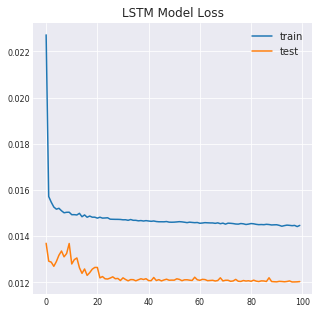

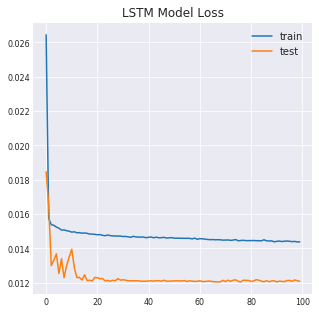

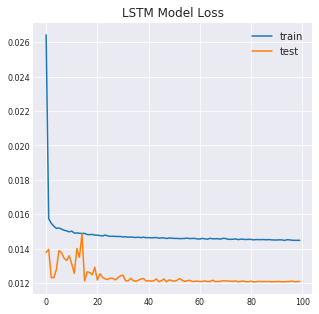

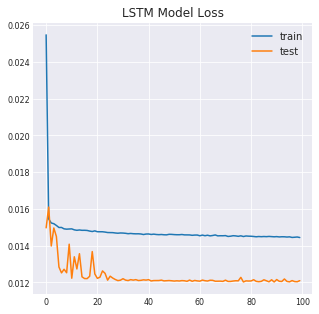

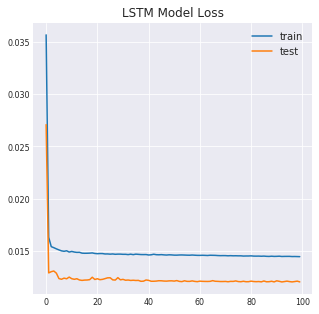

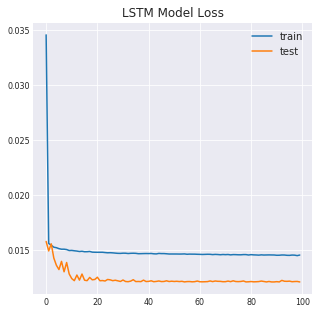

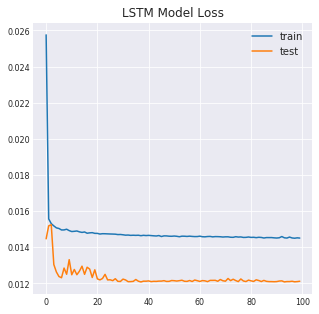

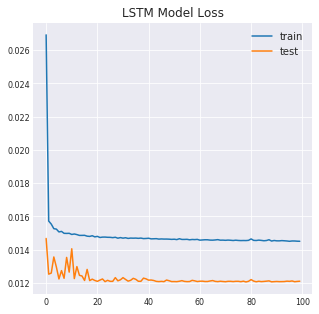

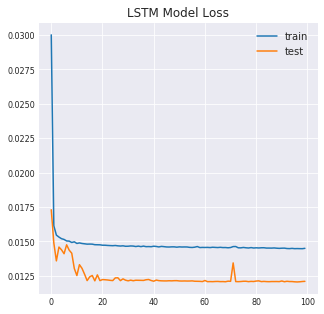

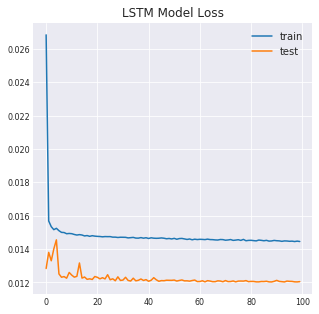

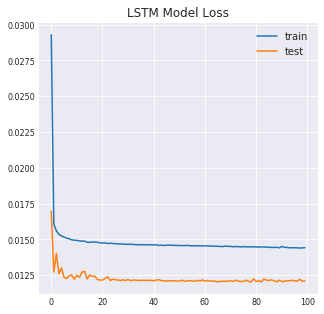

In [6]:
for i in range (13, 24):
    values = total_values[total_values[:, -4] == total_values[i, 1]]
    n_train_hours = 365*3*60
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -1]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

    # design network
    model = Sequential()
    model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    history_loss = pd.DataFrame()
    history_loss['train'] = history.history['loss']
    history_loss['test'] = history.history['val_loss']
    history_loss.plot(figsize=(5,5), fontsize=8,
                title='LSTM Model Loss');
    
    # make a prediction 
    yhat = model.predict(test_X)
    # reshape back to 2d
    test_X = test_X.reshape((test_X.shape[0], -1))

    # invert scaling for forecast 
    inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
    inv_yhat_gte_zero = inv_yhat.copy()
    inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

    # calculate r2
    result[0, i] = r2_score(inv_y, inv_yhat)

    # calculate mean absolute error
    result[1, i] = mean_absolute_error(inv_y, inv_yhat)

    # calculate rmse
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    result[2, i]= rmse

    # calculate mean absolute error percentage
    maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
    result[3, i] = maep
    
    #train error(bias)
    yhat_t = model.predict(train_X)
    # reshape back to 2d
    train_X = train_X.reshape((train_X.shape[0], -1))

    # invert scaling for forecast
    inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
    inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
    inv_yhat_t = inv_yhat_t[:,-1]

    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
    inv_y_t = scaler.inverse_transform(inv_y_t)
    inv_y_t = inv_y_t[:,-1]
    inv_yhat_gte_zero = inv_yhat_t.copy()
    inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

    # exlcude significantly deviated data
    index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)
    
    # calculate mean absolute error percentage
    maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
    
    result[4, i] = maep

In [7]:
result

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.97025674,  0.96993354,
         0.96945309,  0.96948484,  0.96967531,  0.96969957,  0.96939229,
         0.96945197,  0.96942539,  0.97014884,  0.96996597],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 12.12889385, 12.18600559,
        12.18325043, 12.18738651, 12.14083004, 12.15427971, 12.21259499,
        12.19531345, 12.19609737, 12.14093685, 12.18441391],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 15.80181451, 15.88743573,
        16.013869  , 16.00554656, 15.95551697, 15.94913217, 16.02979842,
  